# Python: Average Potential Outcome (APO) Models

In this example, we illustrate how the [DoubleML](https://docs.doubleml.org/stable/index.html) package can be used to estimate average potential outcomes (APOs) in a [DoubleMLIRM](https://docs.doubleml.org/stable/guide/models.html#interactive-regression-model-irm) model.

The goal is to estimate the average potential outcome

 $$\theta_0 =\mathbb{E}[Y(a)]$$

for a given treatment level $a$ and and discrete valued treatment $D$.

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

import doubleml as dml
from doubleml.datasets import make_irm_data_discrete_treatments

## Data Generating Process (DGP)

At first, let us generate data according to the [make_irm_data_discrete_treatments]() data generating process. The process generates data with a continuous
treatment variable and contains the true individual treatment effects (ITEs) with respect to option of not getting treated (the underlying continuous treatment is not required for the model).

According to the continuous treatment variable, the treatment is discretized into multiple levels, based on quantiles. Using the oracle values of the model let us estimate the true APOs and averate treatment effects (ATEs) for the different levels of the treatment variable.


In [2]:
# Parameters
n_obs = 3000
n_levels = 5
linear = True
n_rep = 10

np.random.seed(42)
data_apo = make_irm_data_discrete_treatments(n_obs=n_obs,n_levels=n_levels, linear=linear)

y0 = data_apo['oracle_values']['y0']
cont_d = data_apo['oracle_values']['cont_d']
ite = data_apo['oracle_values']['ite']
d = data_apo['d']
potential_level = data_apo['oracle_values']['potential_level']
level_bounds = data_apo['oracle_values']['level_bounds']

average_ites = np.full(n_levels + 1, np.nan)
apos = np.full(n_levels + 1, np.nan)
mid_points = np.full(n_levels, np.nan)

for i in range(n_levels + 1):
    average_ites[i] = np.mean(ite[d == i]) * (i > 0)
    apos[i] = np.mean(y0) + average_ites[i]

print(f"Average Individual effects in each group:\n{np.round(average_ites,2)}\n")
print(f"Average Potential Outcomes in each group:\n{np.round(apos,2)}\n")
print(f"Levels and their counts:\n{np.unique(d, return_counts=True)}")

Average Individual effects in each group:
[ 0.    1.75  7.03  9.43 10.4  10.49]

Average Potential Outcomes in each group:
[210.04 211.79 217.06 219.47 220.44 220.53]

Levels and their counts:
(array([0., 1., 2., 3., 4., 5.]), array([615, 487, 465, 482, 480, 471]))


To better grasp the distribution of the treatment effects, let us plot the true APOs and ATEs.

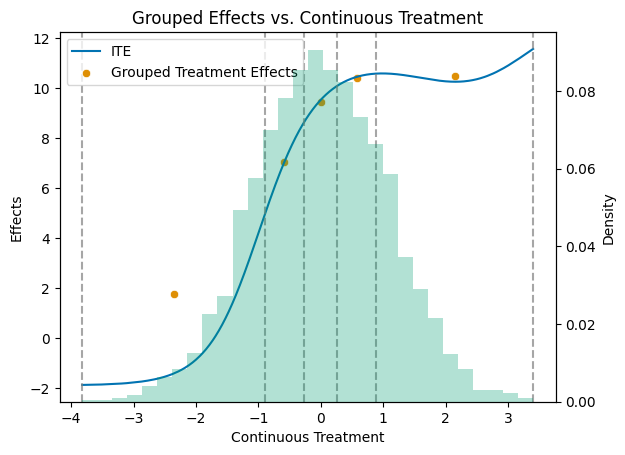

In [3]:
# Get a colorblind-friendly palette
palette = sns.color_palette("colorblind")

df = pd.DataFrame({'cont_d': cont_d, 'ite': ite})
df_sorted = df.sort_values('cont_d')

mid_points = np.full(n_levels, np.nan)
for i in range(n_levels):
    mid_points[i] = (level_bounds[i] + level_bounds[i + 1]) / 2

df_apos = pd.DataFrame({'mid_points': mid_points, 'treatment effects': apos[1:] - apos[0]})

# Create the primary plot with scatter and line plots
fig, ax1 = plt.subplots()

sns.lineplot(data=df_sorted, x='cont_d', y='ite', color=palette[0], label='ITE', ax=ax1)
sns.scatterplot(data=df_apos, x='mid_points', y='treatment effects', color=palette[1], label='Grouped Treatment Effects', ax=ax1)

# Add vertical dashed lines at level_bounds
for bound in level_bounds:
    ax1.axvline(x=bound, color='grey', linestyle='--', alpha=0.7)

ax1.set_title('Grouped Effects vs. Continuous Treatment')
ax1.set_xlabel('Continuous Treatment')
ax1.set_ylabel('Effects')

# Create a secondary y-axis for the histogram
ax2 = ax1.twinx()

# Plot the histogram on the secondary y-axis
ax2.hist(df_sorted['cont_d'], bins=30, alpha=0.3, weights=np.ones_like(df_sorted['cont_d']) / len(df_sorted['cont_d']), color=palette[2])
ax2.set_ylabel('Density')

# Make sure the legend includes all plots
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc='upper left')

plt.show()

As for all [DoubleML](https://docs.doubleml.org/stable/index.html) models, we specify a [DoubleMLData](https://docs.doubleml.org/stable/api/generated/doubleml.DoubleMLData.html#doubleml.DoubleMLData) object to handle the data.

In [4]:
y = data_apo['y']
x = data_apo['x']
d = data_apo['d']
df_apo = pd.DataFrame(
    np.column_stack((y, d, x)),
    columns=['y', 'd'] + ['x' + str(i) for i in range(data_apo['x'].shape[1])]
)

dml_data = dml.DoubleMLData(df_apo, 'y', 'd')
print(dml_data)

================== DoubleMLData Object ==================

------------------ Data summary      ------------------
Outcome variable: y
Treatment variable(s): ['d']
Covariates: ['x0', 'x1', 'x2', 'x3', 'x4']
Instrument variable(s): None
No. Observations: 3000

------------------ DataFrame info    ------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Columns: 7 entries, y to x4
dtypes: float64(7)
memory usage: 164.2 KB



## Single Average Potential Outcome Models (APO)

As for all [DoubleML](https://docs.doubleml.org/stable/index.html) models, we have to specify machine learning algorithms. As in the [DoubleMLIRM](https://docs.doubleml.org/stable/guide/models.html#interactive-regression-model-irm) model, we have to set ''ml_m'' as a classifier and ''ml_g'' as a regressor (since the outcome is continuous).

In [5]:
ml_g = LinearRegression()
ml_m = LogisticRegression()

Further, the [DoubleMLAPO]() model requires a specification of the treatment value for which the APOs should be estimated. In this example, we will loop over all treatment levels.

In [6]:
np.random.seed(42)

treatment_levels = np.unique(d)
thetas = np.full(n_levels + 1, np.nan)
ci = np.full((n_levels + 1, 2), np.nan)

for i_level, treatment_level in enumerate(treatment_levels):
    dml_obj = dml.DoubleMLAPO(
        dml_data,
        ml_g,
        ml_m,
        treatment_level=treatment_level,
        n_rep=n_rep,
    )

    dml_obj.fit()

    thetas[i_level] = dml_obj.coef[0]
    ci[i_level, :] = dml_obj.confint(level=0.95).values

# combine results
df_apo_ci = pd.DataFrame(
    {'treatment_level': treatment_levels,
     'apo': apos,
     'theta': thetas,
     'ci_lower': ci[:, 0],
     'ci_upper': ci[:, 1]}
)

df_apo_ci

,treatment_level,apo,theta,ci_lower,ci_upper
0,0.0,210.036240,210.077702,208.768798,211.386831
1,1.0,211.785815,211.881937,210.545492,213.218383
2,2.0,217.063017,217.069443,215.750701,218.388185
3,3.0,219.468907,219.404300,218.096418,220.712095
4,4.0,220.439699,220.503700,219.186589,221.820963
5,5.0,220.525064,220.417834,219.095104,221.740505


Again, let us summarize the results in a plot of the APOs with confidence intervals.

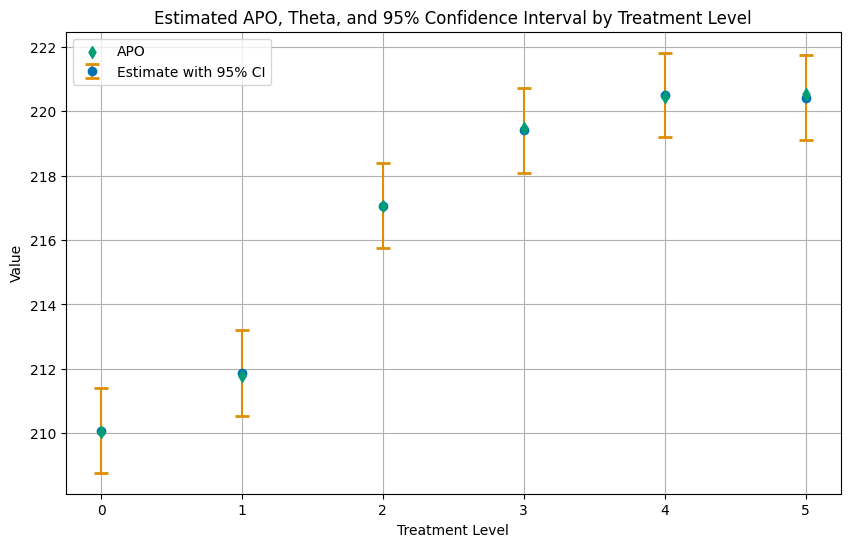

In [7]:
# Plotting
plt.figure(figsize=(10, 6))
# Plot Estimate with 95% CI
plt.errorbar(df_apo_ci['treatment_level'], df_apo_ci['theta'], 
             yerr=[df_apo_ci['theta'] - df_apo_ci['ci_lower'], df_apo_ci['ci_upper'] - df_apo_ci['theta']], 
             fmt='o', capsize=5, capthick=2, ecolor=palette[1], color=palette[0], label='Estimate with 95% CI', zorder=2)
# Plot APO as a scatter plot, with zorder set to 2 to be in front
plt.scatter(df_apo_ci['treatment_level'], df_apo_ci['apo'], color=palette[2], label='APO', marker='d', zorder=3)

plt.title('Estimated APO, Theta, and 95% Confidence Interval by Treatment Level')
plt.xlabel('Treatment Level')
plt.ylabel('Value')
plt.xticks(df_apo_ci['treatment_level'])
plt.legend()
plt.grid(True)
plt.show()

## Multiple Average Potential Outcome Models (APOS)

Instead of looping over different treatment levels, one can directly use the [DoubleMLAPOS]() model which internally combines multiple [DoubleMLAPO]() models. An advantage of this approach is that the model can be parallelized, create joint confidence intervals and allow for a comparison between the average potential outcome levels.

### Average Potential Outcome (APOs)

As before, we just have to specify the machine learning algorithms and the treatment levels for which the APOs should be estimated.

In [8]:
dml_obj = dml.DoubleMLAPOS(
    dml_data,
    ml_g,
    ml_m,
    treatment_levels=treatment_levels,
    n_rep=n_rep,
)

dml_obj.fit()

ci_pointwise = dml_obj.confint(level=0.95)

df_apos_ci = pd.DataFrame(
    {'treatment_level': range(n_levels + 1),
     'apo': apos,
     'theta': thetas,
     'ci_lower': ci_pointwise.values[:, 0],
     'ci_upper': ci_pointwise.values[:, 1]}
)

df_apos_ci

,treatment_level,apo,theta,ci_lower,ci_upper
0,0,210.036240,210.077702,208.766940,211.384677
1,1,211.785815,211.881937,210.553004,213.225427
2,2,217.063017,217.069443,215.756200,218.393654
3,3,219.468907,219.404300,218.108259,220.723846
4,4,220.439699,220.503700,219.192952,221.828157
5,5,220.525064,220.417834,219.095785,221.741523


Again, let us summarize the results in a plot.

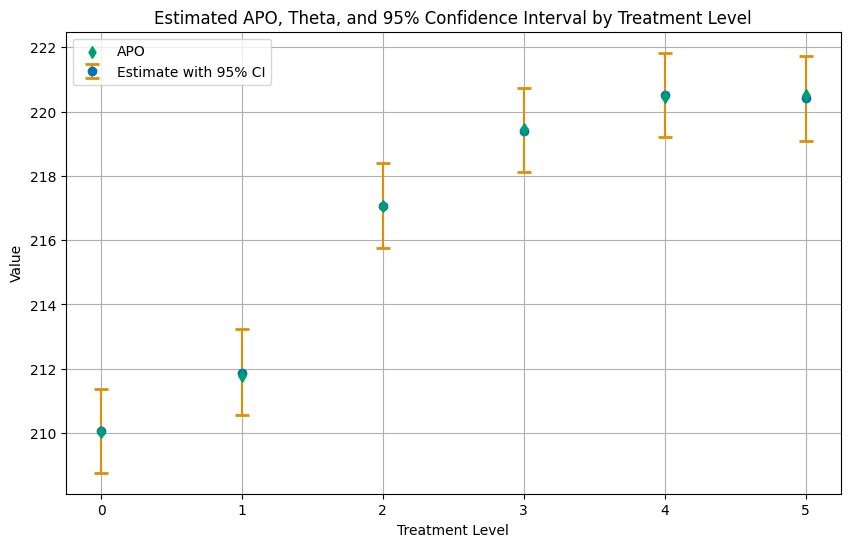

In [9]:
# Plotting
plt.figure(figsize=(10, 6))
# Plot Estimate with 95% CI
plt.errorbar(df_apos_ci['treatment_level'], df_apos_ci['theta'], 
             yerr=[df_apos_ci['theta'] - df_apos_ci['ci_lower'], df_apos_ci['ci_upper'] - df_apos_ci['theta']], 
             fmt='o', capsize=5, capthick=2, ecolor=palette[1], color=palette[0], label='Estimate with 95% CI', zorder=2)
# Plot APO as a scatter plot, with zorder set to 2 to be in front
plt.scatter(df_apos_ci['treatment_level'], df_apos_ci['apo'], color=palette[2], label='APO', marker='d', zorder=3)

plt.title('Estimated APO, Theta, and 95% Confidence Interval by Treatment Level')
plt.xlabel('Treatment Level')
plt.ylabel('Value')
plt.xticks(df_apos_ci['treatment_level'])
plt.legend()
plt.grid(True)
plt.show()

## Sensitivity Analysis

For [DoubleMLAPO]() and [DoubleMLAPOS]() model all methods for sensitivity analysis are available.

In [10]:
dml_obj.sensitivity_analysis()
print(dml_obj.sensitivity_summary)

================== Sensitivity Analysis ==================

------------------ Scenario          ------------------
Significance Level: level=0.95
Sensitivity parameters: cf_y=0.03; cf_d=0.03, rho=1.0

------------------ Bounds with CI    ------------------
     CI lower  theta lower       theta  theta upper    CI upper
0  208.728734   209.827445  210.075809   210.324476  211.422561
1  210.397179   211.516945  211.889638   212.261520  213.385013
2  215.581896   216.687697  217.074927   217.461646  218.569444
3  217.966320   219.064175  219.416052   219.767616  220.865074
4  219.057274   220.163816  220.510555   220.857294  221.962523
5  218.890229   220.003111  220.418741   220.832078  221.940450

------------------ Robustness Values ------------------
   H_0     RV (%)    RVa (%)
0  0.0  99.849245  99.835822
1  0.0  99.670785  99.622750
2  0.0  99.659361  99.625183
3  0.0  99.725080  99.699543
4  0.0  99.734278  99.708821
5  0.0  99.621902  99.577647


Additionally, ``sensitvity_benchmark`` can be used. In this example we benchmark covariate ``x4`` which does not affect treatment $D$ or outcome $Y$.

In [11]:
dml_obj.sensitivity_benchmark(benchmarking_set=['x4'])

,cf_y,cf_d,rho,delta_theta
0.0,0.0,0.000000,0.0,0.000006
1.0,0.0,0.000000,-1.0,-0.004253
2.0,0.0,0.000000,1.0,0.003220
3.0,0.0,0.000000,-1.0,-0.004526
4.0,0.0,0.003415,1.0,0.003404
5.0,0.0,0.000000,-1.0,-0.006055


 For more details on the sensitivity analysis, please refer to the [User Guide](https://docs.doubleml.org/stable/guide/sensitivity.html).

### Causal Contrats

The [DoubleMLAPOS]() model also allows for the estimation of causal contrasts. 
The contrast is defined as the difference in the average potential outcomes between the treatment levels $a_i$ and $a_j$ where

$$ \theta_0 = \mathbb{E}[Y(a_i)] - \mathbb{E}[Y(a_{j})]$$

and will be calculated for all defined treatment levels $i$ and reference levels $j$.

In this example, we will estimate the causal contrast between the treatment level $0$ and all other treatment levels, as the treatment level $0$ correspondonds to no treatment at all whereas the the other levels are based on the treatment dosage.

Therefore we have to specify ``reference_levels=0``.

In [12]:
causal_contrast_model = dml_obj.causal_contrast(reference_levels=0)

ates = causal_contrast_model.thetas
ci_ates = causal_contrast_model.confint(level=0.95)

df_ates = pd.DataFrame(
    {'treatment_level': treatment_levels[1:],
     'ate': ates,
     'ci_lower': ci_ates.iloc[:, 0].values,
     'ci_upper': ci_ates.iloc[:, 1].values}
)
df_ates

,treatment_level,ate,ci_lower,ci_upper
0,1.0,1.810306,1.454406,2.165707
1,2.0,6.994208,6.710059,7.278035
2,3.0,9.335446,9.068934,9.600776
3,4.0,10.431998,10.155160,10.708837
4,5.0,10.342362,10.039141,10.645583


Finally, let us summarize the results in a plot.

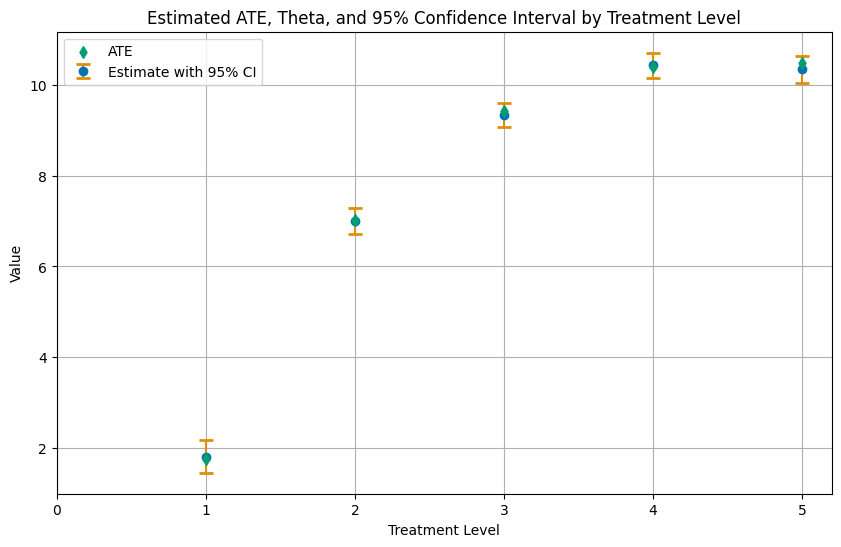

In [13]:
# Plotting
plt.figure(figsize=(10, 6))
# Plot Estimate with 95% CI
plt.errorbar(df_ates['treatment_level'], df_ates['ate'],
             yerr=[df_ates['ate'] - df_ates['ci_lower'], df_ates['ci_upper'] - df_ates['ate']], 
             fmt='o', capsize=5, capthick=2, ecolor=palette[1], color=palette[0], label='Estimate with 95% CI', zorder=2)
# Plot APO as a scatter plot, with zorder set to 2 to be in front
plt.scatter(df_apos_ci['treatment_level'][1:], average_ites[1:], color=palette[2], label='ATE', marker='d', zorder=3)

plt.title('Estimated ATE, Theta, and 95% Confidence Interval by Treatment Level')
plt.xlabel('Treatment Level')
plt.ylabel('Value')
plt.xticks(df_apos_ci['treatment_level'])
plt.legend()
plt.grid(True)
plt.show()

The methods ``sensitivity_analysis`` and ``sensitivity_plot`` are also available for the causal contrasts.

In [17]:
causal_contrast_model.sensitivity_analysis()
print(causal_contrast_model.sensitivity_summary)

================== Sensitivity Analysis ==================

------------------ Scenario          ------------------
Significance Level: level=0.95
Sensitivity parameters: cf_y=0.03; cf_d=0.03, rho=1.0

------------------ Bounds with CI    ------------------
            CI lower  theta lower      theta  theta upper   CI upper
1.0 vs 0.0  0.978997     1.278522   1.810306     2.344753   2.640334
2.0 vs 0.0  6.200065     6.441676   6.994208     7.546266   7.782117
3.0 vs 0.0  8.599208     8.825801   9.335446     9.842589  10.063685
4.0 vs 0.0  9.698651     9.934068  10.431998    10.933259  11.163577
5.0 vs 0.0  9.536219     9.797157  10.342362    10.887197  11.138953

------------------ Robustness Values ------------------
            H_0     RV (%)    RVa (%)
1.0 vs 0.0  0.0   9.818313   8.218176
2.0 vs 0.0  0.0  31.816645  30.614201
3.0 vs 0.0  0.0  42.377195  41.204626
4.0 vs 0.0  0.0  46.536082  45.315223
5.0 vs 0.0  0.0  43.385615  41.944839


As an example see the ``sensitivity_plot`` for the first causal contrast ``1.0 vs 0.0``.

In [20]:
causal_contrast_model.sensitivity_plot(idx_treatment=0)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'contours': {'coloring': 'heatmap', 'labelfont': {'color': 'white', 'size': 12}, 'showlabels': True},
              'hovertemplate': 'cf_d: %{x:.3f}<br>cf_y : %{y:.3f}</b><br>Bound: %{z:.3f}</b>',
              'name': 'Contour',
              'type': 'contour',
              'x': array([0.        , 0.00151515, 0.0030303 , 0.00454545, 0.00606061, 0.00757576,
                          0.00909091, 0.01060606, 0.01212121, 0.01363636, 0.01515152, 0.01666667,
                          0.01818182, 0.01969697, 0.02121212, 0.02272727, 0.02424242, 0.02575758,
                          0.02727273, 0.02878788, 0.03030303, 0.03181818, 0.03333333, 0.03484848,
                          0.03636364, 0.03787879, 0.03939394, 0.04090909, 0.04242424, 0.04393939,
                          0.04545455, 0.0469697 , 0.04848485, 0.05      , 0.05151515, 0.0530303 ,
                          0.05454545, 0.05606061, 0.05757576, 0.05909091, 0.06060606, 0.06212121,
                          0.06363636, 0.06515152, 0.06666667, 0.06818182, 0.06969697, 0.07121212,
                          0.07272727, 0.07424242, 0.07575758, 0.07727273, 0.07878788, 0.08030303,
                          0.08181818, 0.08333333, 0.08484848, 0.08636364, 0.08787879, 0.08939394,
                          0.09090909, 0.09242424, 0.09393939, 0.09545455, 0.0969697 , 0.09848485,
                          0.1       , 0.10151515, 0.1030303 , 0.10454545, 0.10606061, 0.10757576,
                          0.10909091, 0.11060606, 0.11212121, 0.11363636, 0.11515152, 0.11666667,
                          0.11818182, 0.11969697, 0.12121212, 0.12272727, 0.12424242, 0.12575758,
                          0.12727273, 0.12878788, 0.13030303, 0.13181818, 0.13333333, 0.13484848,
                          0.13636364, 0.13787879, 0.13939394, 0.14090909, 0.14242424, 0.14393939,
                          0.14545455, 0.1469697 , 0.14848485, 0.15      ]),
              'y': array([0.        , 0.00151515, 0.0030303 , 0.00454545, 0.00606061, 0.00757576,
                          0.00909091, 0.01060606, 0.01212121, 0.01363636, 0.01515152, 0.01666667,
                          0.01818182, 0.01969697, 0.02121212, 0.02272727, 0.02424242, 0.02575758,
                          0.02727273, 0.02878788, 0.03030303, 0.03181818, 0.03333333, 0.03484848,
                          0.03636364, 0.03787879, 0.03939394, 0.04090909, 0.04242424, 0.04393939,
                          0.04545455, 0.0469697 , 0.04848485, 0.05      , 0.05151515, 0.0530303 ,
                          0.05454545, 0.05606061, 0.05757576, 0.05909091, 0.06060606, 0.06212121,
                          0.06363636, 0.06515152, 0.06666667, 0.06818182, 0.06969697, 0.07121212,
                          0.07272727, 0.07424242, 0.07575758, 0.07727273, 0.07878788, 0.08030303,
                          0.08181818, 0.08333333, 0.08484848, 0.08636364, 0.08787879, 0.08939394,
                          0.09090909, 0.09242424, 0.09393939, 0.09545455, 0.0969697 , 0.09848485,
                          0.1       , 0.10151515, 0.1030303 , 0.10454545, 0.10606061, 0.10757576,
                          0.10909091, 0.11060606, 0.11212121, 0.11363636, 0.11515152, 0.11666667,
                          0.11818182, 0.11969697, 0.12121212, 0.12272727, 0.12424242, 0.12575758,
                          0.12727273, 0.12878788, 0.13030303, 0.13181818, 0.13333333, 0.13484848,
                          0.13636364, 0.13787879, 0.13939394, 0.14090909, 0.14242424, 0.14393939,
                          0.14545455, 0.1469697 , 0.14848485, 0.15      ]),
              'z': array([[ 1.81030604,  1.81030604,  1.81030604, ...,  1.81030604,  1.81030604,
                            1.81030604],
                          [ 1.81030604,  1.78370159,  1.77268167, ...,  1.54872352,  1.54738733,
                            1.54605794],
                          [ 1.81030604,  1.77265309,  1.75705672, ...,  1.44079575,  1.43890466,
                            1.43702319],
            

Benchmarking is not available for causal contrasts.